# Churn prediction:
Academic exploration, based on this article: https://medium.com/@ramazanolmeez/end-to-end-machine-learning-project-churn-prediction-e9c4d0322ac9

## Download dataset:

In [1]:
# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import os

from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, classification_report, recall_score, confusion_matrix,
    roc_auc_score, precision_score, f1_score, roc_curve, auc
)
from sklearn.preprocessing import OrdinalEncoder

from catboost import CatBoostClassifier, Pool

In [2]:
df = pd.read_csv('C:/Users/USER/Documents/Portafolio DS/Portafolio/Churn_Prediction/data/churn-prediction-telco/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


## Data preprocessing:

In [4]:
# Update format of the columns:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

In [5]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['tenure'] * df['MonthlyCharges'])

In [6]:
# Replace 'No phone service' and 'No internet service' with 'No' for certain columns
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
columns_to_replace = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for column in columns_to_replace:
    df[column] = df[column].replace('No internet service', 'No')

# Convert 'Churn' categorical variable to numeric
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

C:\Users\USER\AppData\Local\Temp\ipykernel_11524\3750689165.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})


In [13]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0


In [39]:
columns_to_drop = ['customerID']
df_clean = df.drop(columns=columns_to_drop).copy()

## Create Stratified Split:

In [40]:
# Identify categorical columns
categorical_columns = df_clean.select_dtypes(include=['object']).columns.tolist()
df_clean[categorical_columns] = df_clean[categorical_columns].astype("category")

In [34]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [42]:
train_index, test_index = next(strat_split.split(df_clean, df_clean["Churn"]))

In [43]:
# Create train and test sets
strat_train_set = df_clean.loc[train_index]
strat_test_set = df_clean.loc[test_index]

X_train = strat_train_set.drop("Churn", axis=1)
y_train = strat_train_set["Churn"].copy()

X_test = strat_test_set.drop("Churn", axis=1)
y_test = strat_test_set["Churn"].copy()

In [50]:
# Initialize and fit CatBoostClassifier
cat_model = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=3)
cat_model.fit(X_train, y_train, cat_features=categorical_columns, eval_set=(X_test, y_test))

# Predict on test set
y_pred_cat = cat_model.predict(X_test)

In [58]:
from sklearn.metrics import classification_report, confusion_matrix

# Metric report por CatBoost:
confusion_matrix_catboost = confusion_matrix(y_test, y_pred_cat)
print(classification_report(y_test, y_pred_cat))


              precision    recall  f1-score   support

           0       0.92      0.72      0.81      1035
           1       0.51      0.82      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



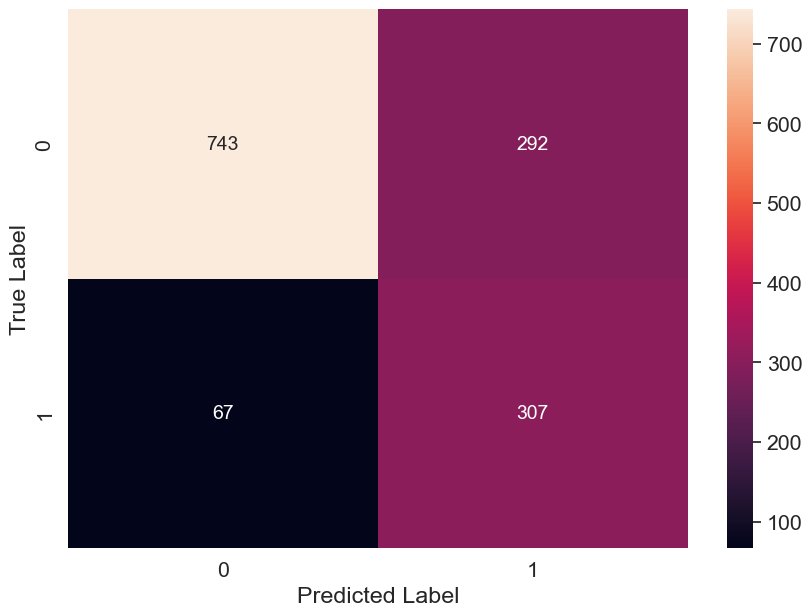

In [71]:
df_cm = pd.DataFrame(confusion_matrix_catboost)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='d') # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 1.2 MB/s eta 0:01:27
   ---------------------------------------- 0.3/99.8 MB 2.8 MB/s eta 0:00:36
   ---------------------------------------- 0.4/99.8 MB 2.4 MB/s eta 0:00:41
   ---------------------------------------- 0.5/99.8 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 0.5/99.8 MB 2.3 MB/s eta 0:00:44
   ---------------------------------------- 0.5/99.8 MB 1.7 MB/s eta 0:01:00
   ---------------------------------------- 0.6/99.8 MB 1.8 MB/s eta 0:00:56
   ---------------------------------------- 0.6/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 0.6/99.8 MB 1.4 MB/s eta 0:01:10
   ---------------------------------------- 0.7/99.8 MB 1.4 MB/s eta 0:01:11
   ---------------------------------------- 0.7/99.8 MB 1.5 MB/s eta 0:01:08
   ----------

In [73]:
# Testing XGBoost:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2, enable_categorical=True)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-logloss:0.50491
[1]	validation_0-logloss:0.46891
[2]	validation_0-logloss:0.44926
[3]	validation_0-logloss:0.43824
[4]	validation_0-logloss:0.43149
[5]	validation_0-logloss:0.42760
[6]	validation_0-logloss:0.42408
[7]	validation_0-logloss:0.42499
[8]	validation_0-logloss:0.42417


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
y_pred_xgboost = clf.predict(X_test)

In [66]:
# Metric report por XGBoost:
confusion_matrix_xgboost = confusion_matrix(y_test, y_pred_xgboost)
print(classification_report(y_test, y_pred_xgboost))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.49      0.56       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



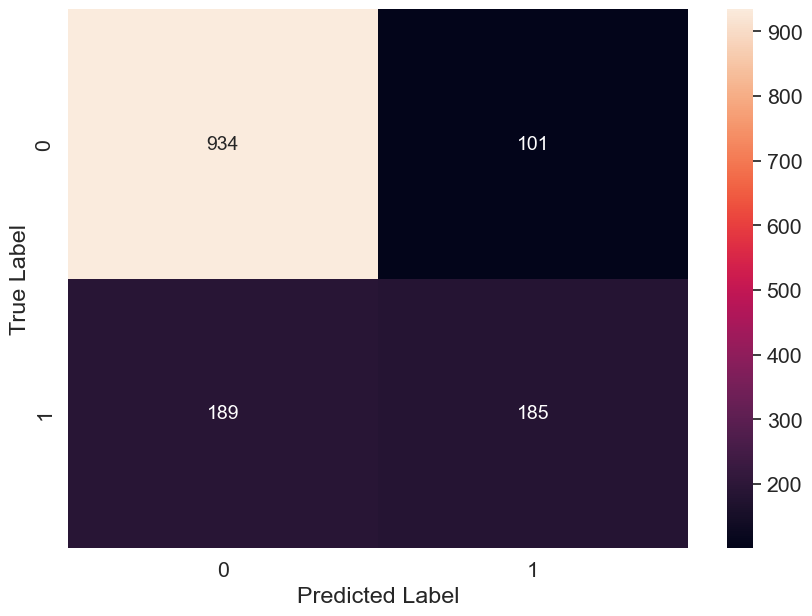

In [70]:
df_cm = pd.DataFrame(confusion_matrix_xgboost)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='d') # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [74]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, 10, 20]  # Important for imbalanced datasets
}

# Create the XGBoost classifier
clf = xgb.XGBClassifier(tree_method="hist", enable_categorical=True, use_label_encoder=False)

# Create a scorer for recall
recall_scorer = make_scorer(recall_score, average='binary')

# Set up the grid search with cross-validation
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=2)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[0]	validation_0-logloss:1.30419
[1]	validation_0-logloss:1.29869
[2]	validation_0-logloss:1.29224
[3]	validation_0-logloss:1.28908
[4]	validation_0-logloss:1.28730
[5]	validation_0-logloss:1.28498
[6]	validation_0-logloss:1.28074
[7]	validation_0-logloss:1.27636
[8]	validation_0-logloss:1.27018
[9]	validation_0-logloss:1.26464
[10]	validation_0-logloss:1.26245
[11]	validation_0-logloss:1.25880
[12]	validation_0-logloss:1.25650
[13]	validation_0-logloss:1.25248
[14]	validation_0-logloss:1.25262
[15]	validation_0-logloss:1.24776
[16]	validation_0-logloss:1.24399
[17]	validation_0-logloss:1.24044
[18]	validation_0-logloss:1.23845
[19]	validation_0-logloss:1.23386
[20]	validation_0-logloss:1.23025
[21]	validation_0-logloss:1.22586
[22]	validation_0-logloss:1.22478
[23]	validation_0-logloss:1.22075
[24]	validation_0-logloss:1.21663
[25]	validation_0-logloss:1.21537
[26]	validation_0-logloss:1.21435
[27]	validation_0-logloss:1.

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [1, 10, 20],
                         'subsample': [0.5, 0.7, 1.0]},
             scoring=make_scorer(recall_score, response_method='predict', average=binary),
             verbose=1)

In [75]:
# Print the best parameters and the best recall score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best recall score: {grid_search.best_score_}")

Best parameters found: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 20, 'subsample': 1.0}
Best recall score: 0.9966555183946488


In [79]:
# Use the best estimator for predictions
best_clf = grid_search.best_estimator_
y_pred_xgboost_tunned = best_clf.predict(X_test)

In [81]:
# Metric report por XGBoost:
confusion_matrix_xgboost_tunned = confusion_matrix(y_test, y_pred_xgboost_tunned)
print(classification_report(y_test, y_pred_xgboost))

              precision    recall  f1-score   support

           0       1.00      0.11      0.19      1035
           1       0.29      1.00      0.45       374

    accuracy                           0.34      1409
   macro avg       0.64      0.55      0.32      1409
weighted avg       0.81      0.34      0.26      1409



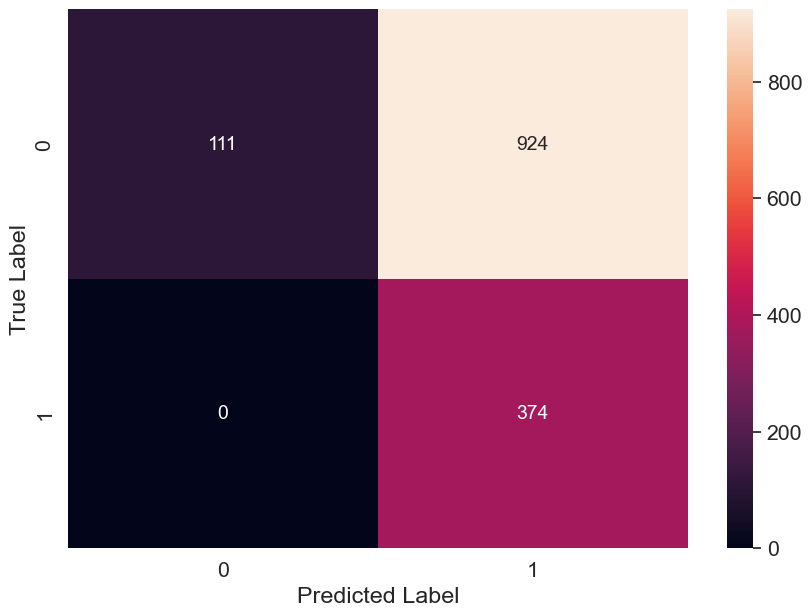

In [82]:
df_cm = pd.DataFrame(confusion_matrix_xgboost_tunned)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='d') # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [85]:
len(best_clf.predict_proba(X_test)[:, 1])

1409

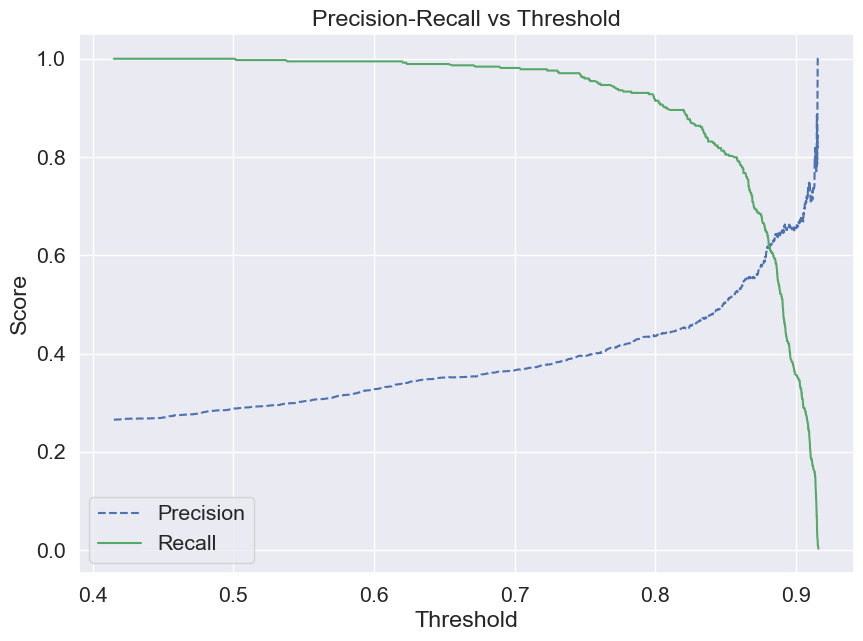

In [87]:
from sklearn.metrics import precision_recall_curve, recall_score, precision_score

# Get the predicted probabilities
y_probs = best_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Compute precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

In [88]:
# Find the best threshold based on some criteria
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f"Best threshold: {best_threshold}")
print(f"Precision at best threshold: {precision[best_threshold_index]}")
print(f"Recall at best threshold: {recall[best_threshold_index]}")

# Predict using the best threshold
y_pred_best_threshold = (y_probs >= best_threshold).astype(int)

# Calculate and print precision and recall at the best threshold
precision_best_threshold = precision_score(y_test, y_pred_best_threshold)
recall_best_threshold = recall_score(y_test, y_pred_best_threshold)
print(f"Precision at best threshold: {precision_best_threshold}")
print(f"Recall at best threshold: {recall_best_threshold}")

Best threshold: 0.8643127083778381
Precision at best threshold: 0.551923076923077
Recall at best threshold: 0.767379679144385
Precision at best threshold: 0.551923076923077
Recall at best threshold: 0.767379679144385


In [94]:
# Predict using the best threshold
y_pred_best_threshold = (y_probs >= best_threshold).astype(int)

# Metric report por XGBoost:
confusion_matrix_xgboost_tunned_best_threshold = confusion_matrix(y_test, y_pred_best_threshold)
print(classification_report(y_test, y_pred_best_threshold))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.55      0.77      0.64       374

    accuracy                           0.77      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.77      0.78      1409



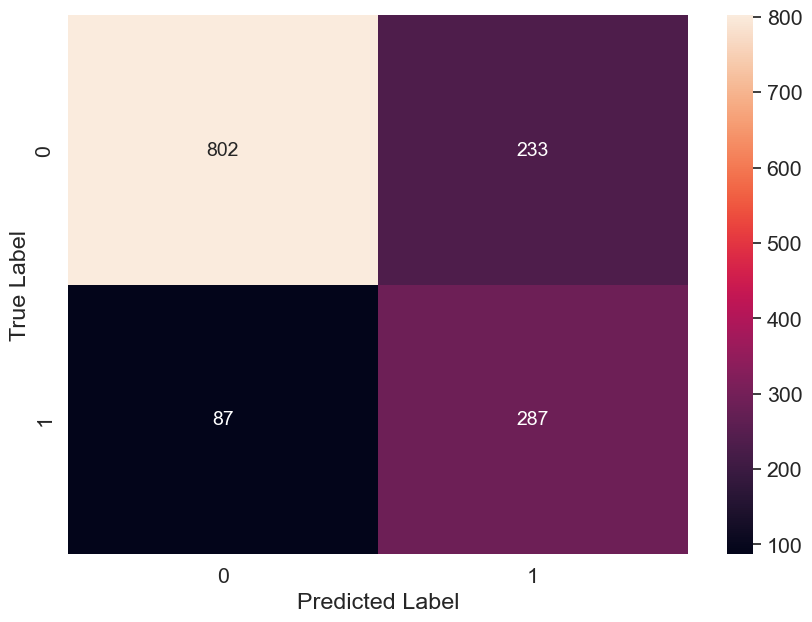

In [95]:
df_cm = pd.DataFrame(confusion_matrix_xgboost_tunned_best_threshold)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='d') # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [98]:
# Save the model in the 'model' directory
model_dir = "../Churn_Prediction/model_final"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, "xgboost_model.json")
best_clf.save_model(model_path)

# The model selected was XGBoost with the threshold in 0.86. It was saved in the folder "model_final" and it's ready to use.